# Emergency Vehicle Detector

## Project done by : Jaitashri Poddar

# Project Description

Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services. <br> <br>
In this project, the created deep learning based model classifies vehicle images as either emergency or non-emergency. Emergency vehicles typically include police cars, ambulances, and fire brigades. 

# Data Description

The training and testing datasets have been taken from [Kaggle](https://www.kaggle.com/datasets/abhisheksinghblr/emergency-vehicles-identification). <br>
**train.zip:** contains 2 csvs and 1 folder containing image data <br>
**train.csv** – [‘image_names’, ‘emergency_or_not’] contains the image name and correct class for 1646 (70%) train images <br>
**images** – contains 2352 images for both train and test sets <br>
**test.csv:** [‘image_names’] contains just the image names for the 706 (30%) test images

# 1. Importing Libraries and Setting Options

## 1.1 Importing Necessary LIbraries

In [1]:
# suppress display of warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the NumPy library for numerical operations
import numpy as np

# Importing the Pandas library for data manipulation and analysis
import pandas as pd

# Importing the Matplotlib library for plotting and visualization
import matplotlib.pyplot as plt

# Importing the train_test_split function from scikit-learn for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Importing the shuffle function from scikit-learn for shuffling the dataset
from sklearn.utils import shuffle

# Importing the ImageDataGenerator class from TensorFlow Keras for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing the Sequential class from TensorFlow Keras to initialize a sequential model
from tensorflow.keras.models import Sequential

# Import the VGG16 and ResNet-50 model architectures from TensorFlow Keras applications
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

# Importing various layers from TensorFlow Keras for building the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Import the Adam optimizer from the legacy module of TensorFlow Keras optimizers
from tensorflow.keras.optimizers.legacy import Adam

# Importing the EarlyStopping callback from TensorFlow Keras to stop training when a monitored metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping

# Import the load_model function from TensorFlow Keras
from tensorflow.keras.models import load_model

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-07-13 23:38:35.987719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2 Setting Figure Size

In [2]:
# set the plot size using 'rcParams'
# once the plot size is set using 'rcParams', it sets the size of all the forthcoming plots in the file
# pass width and height in inches to 'figure.figsize' 
plt.rcParams['figure.figsize'] = [15,8]

## 1.3 Setting Options

In [3]:
# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# use below code to convert the 'exponential' values to float
np.set_printoptions(suppress=True)

# 2. Loading Data

In [4]:
#Let's name the dataset as train_data
train_data = pd.read_csv('train.csv')

In [5]:
train_data.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB


# 3. Data Preprocessing and Analysis

In [7]:
#Let's convert the target column to string
train_data['emergency_or_not'] = train_data['emergency_or_not'].astype('string') 

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   string
dtypes: object(1), string(1)
memory usage: 25.8+ KB


In [9]:
train_data['emergency_or_not'].value_counts()

emergency_or_not
0    965
1    681
Name: count, dtype: Int64

In [10]:
# Data preprocessing

# Images are stored in a folder named 'train'
# Create a list of image paths by concatenating the folder name with image file names from the 'train_data' DataFrame
image_paths = ['train/' + img_name for img_name in train_data['image_names']]

# Extract the labels for each image from the 'train_data' DataFrame
labels = train_data['emergency_or_not']

In [11]:
# Split the data into training and validation sets

# Use train_test_split to split the image paths and labels into training and validation sets
# test_size=0.2 means 20% of the data will be used for validation
# random_state=42 ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

## Data Augmentation

In [12]:
# Initialize ImageDataGenerator for training data with rescaling
# rescale=1./255 scales the pixel values to the range [0, 1]
# We should not perform data augmentation on the test or validation data
train_datagen = ImageDataGenerator(rescale=1./255)

# Initialize ImageDataGenerator for validation data with rescaling
# Again, we should not perform data augmentation on the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training set
# flow_from_dataframe generates batches of tensor image data with real-time data augmentation
# dataframe contains image paths and corresponding labels
# x_col specifies the column in the dataframe that contains the image paths
# y_col specifies the column that contains the labels
# target_size resizes all images to 224x224 pixels
# batch_size specifies the number of images to be yielded from the generator per batch
# class_mode='binary' because we have binary classification (emergency or non-emergency)
train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image_paths': X_train, 'labels': y_train}),
                                                    x_col='image_paths', y_col='labels',
                                                    target_size=(224, 224), batch_size=32, class_mode='binary')

# Create a data generator for the validation set using the same parameters as for the training set
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image_paths': X_val, 'labels': y_val}),
                                                x_col='image_paths', y_col='labels',
                                                target_size=(224, 224), batch_size=32, class_mode='binary')


Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


# 4. Model Building

## 4.1 Using Custom Model

In [13]:
# Define the model architecture

# Initialize a Sequential model
custom_model = Sequential([
    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and input shape 224x224x3 (for RGB images)
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    
    # Add a 2D max pooling layer with a 2x2 pool size to reduce the spatial dimensions
    MaxPooling2D((2, 2)),
    
    # Add another 2D convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    
    # Add another 2D max pooling layer with a 2x2 pool size
    MaxPooling2D((2, 2)),
    
    # Add another 2D convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    
    # Add another 2D max pooling layer with a 2x2 pool size
    MaxPooling2D((2, 2)),
    
    # Flatten the 3D output to 1D for the fully connected layers
    Flatten(),
    
    # Add a fully connected (dense) layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    
    # Add a dropout layer with a 50% dropout rate to prevent overfitting
    Dropout(0.5),
    
    # Add the output layer with 1 unit and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

2024-07-13 23:38:39.492351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Compile the model

# Compile the model with the following parameters:
# optimizer='adam': Use the Adam optimizer for training
# loss='binary_crossentropy': Use binary cross-entropy as the loss function since this is a binary classification problem
# metrics=['accuracy']: Evaluate the model using accuracy as the metric
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model

# Set up early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
# restore_best_weights=True ensures that the model will restore the weights from the epoch with the best validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the fit method
# train_generator: The training data generator
# steps_per_epoch: The number of steps (batches of samples) to yield from the generator before declaring one epoch finished
# epochs: The number of epochs to train the model
# validation_data: The validation data generator
# validation_steps: The number of steps (batches of samples) to yield from the validation generator
# callbacks: A list of callback instances to apply during training (here we use early stopping)
history = custom_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                           validation_data=val_generator, validation_steps=len(X_val)//32,
                           callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 41s 987ms/step - loss: 0.7645 - accuracy: 0.6223 - val_loss: 0.6084 - val_accuracy: 0.6875
Epoch 2/50
41/41 [==============================] - 42s 1s/step - loss: 0.5329 - accuracy: 0.7321 - val_loss: 0.5161 - val_accuracy: 0.7625
Epoch 3/50
41/41 [==============================] - 47s 1s/step - loss: 0.4678 - accuracy: 0.7812 - val_loss: 0.4746 - val_accuracy: 0.7875
Epoch 4/50
41/41 [==============================] - 47s 1s/step - loss: 0.3893 - accuracy: 0.8372 - val_loss: 0.4413 - val_accuracy: 0.7969
Epoch 5/50
41/41 [==============================] - 49s 1s/step - loss: 0.3178 - accuracy: 0.8645 - val_loss: 0.4324 - val_accuracy: 0.8062
Epoch 6/50
41/41 [==============================] - 49s 1s/step - loss: 0.2560 - accuracy: 0.9058 - val_loss: 0.4430 - val_accuracy: 0.7937
Epoch 7/50
41/41 [==============================] - 45s 1s/step - loss: 0.1674 - accuracy: 0.9338 - val_loss: 0.4791 - val_accuracy: 0.8125
Epoch 8/50
41/41 

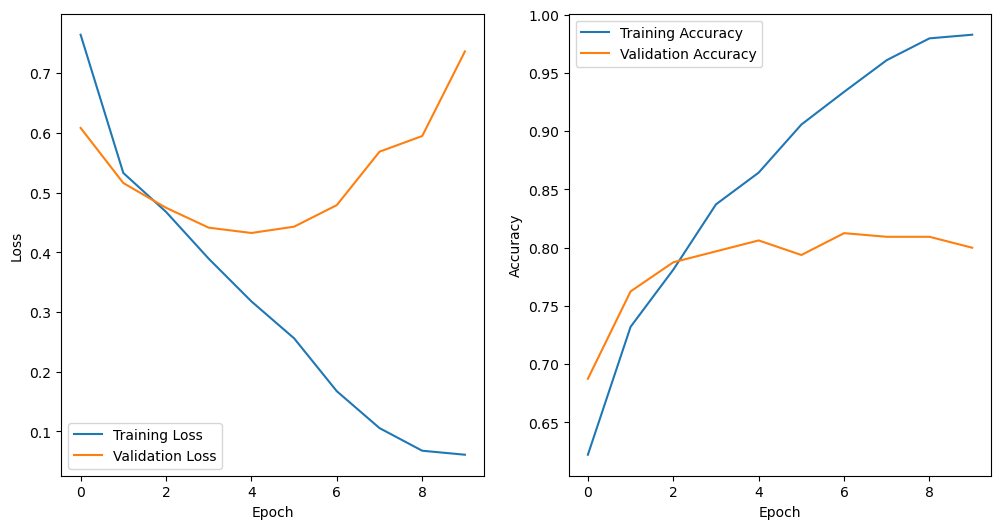

In [16]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on validation data

# Use the evaluate method to assess the model's performance on the validation data
# val_generator: The validation data generator
loss, accuracy = custom_model.evaluate(val_generator)

# Print the validation loss and accuracy
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

11/11 [==============================] - 4s 328ms/step - loss: 0.4260 - accuracy: 0.8091
Validation Loss: 0.4259549677371979
Validation Accuracy: 0.8090909123420715


## 4.2 VGG16 Model

In [18]:
# Load the VGG16 model pre-trained on ImageNet without the top layer

# VGG16 is loaded with pre-trained weights from ImageNet
# include_top=False excludes the fully connected layers at the top of the network
# input_shape specifies the shape of the input images (224x224 pixels with 3 color channels)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
# Freeze the convolutional base

# Iterate through each layer in the base_model and set its trainable attribute to False
# This prevents the weights in these layers from being updated during training
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# Create the model architecture by adding custom top layers

# Initialize a Sequential model
vgg16_model = Sequential([
    # Add the pre-trained VGG16 model as the base
    base_model,
    
    # Flatten the 3D output to 1D for the fully connected layers
    Flatten(),
    
    # Add a fully connected (dense) layer with 256 units and ReLU activation
    Dense(256, activation='relu'),
    
    # Add a dropout layer with a 50% dropout rate to prevent overfitting
    Dropout(0.5),
    
    # Add the output layer with 1 unit and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

In [21]:
# Compile the model

# Compile the VGG16 model with the following parameters:
# optimizer='adam': Use the Adam optimizer for training
# loss='binary_crossentropy': Use binary cross-entropy as the loss function since this is a binary classification problem
# metrics=['accuracy']: Evaluate the model using accuracy as the metric
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Print a summary of the model architecture
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
# Train the model

# Set up early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
# restore_best_weights=True ensures that the model will restore the weights from the epoch with the best validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the VGG16 model using the fit method
# train_generator: The training data generator
# steps_per_epoch: The number of steps (batches of samples) to yield from the generator before declaring one epoch finished
# epochs: The number of epochs to train the model
# validation_data: The validation data generator
# validation_steps: The number of steps (batches of samples) to yield from the validation generator
# callbacks: A list of callback instances to apply during training (here we use early stopping)
history = vgg16_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                          validation_data=val_generator, validation_steps=len(X_val)//32,
                          callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 463s 11s/step - loss: 1.1421 - accuracy: 0.7422 - val_loss: 0.2732 - val_accuracy: 0.8938
Epoch 2/50
41/41 [==============================] - 511s 13s/step - loss: 0.2367 - accuracy: 0.9097 - val_loss: 0.3091 - val_accuracy: 0.8719
Epoch 3/50
41/41 [==============================] - 497s 12s/step - loss: 0.1712 - accuracy: 0.9330 - val_loss: 0.2313 - val_accuracy: 0.9187
Epoch 4/50
41/41 [==============================] - 556s 14s/step - loss: 0.1310 - accuracy: 0.9618 - val_loss: 0.4164 - val_accuracy: 0.8469
Epoch 5/50
41/41 [==============================] - 545s 13s/step - loss: 0.1317 - accuracy: 0.9509 - val_loss: 0.2307 - val_accuracy: 0.9031
Epoch 6/50
41/41 [==============================] - 569s 14s/step - loss: 0.0946 - accuracy: 0.9688 - val_loss: 0.2007 - val_accuracy: 0.9281
Epoch 7/50
41/41 [==============================] - 576s 14s/step - loss: 0.0507 - accuracy: 0.9836 - val_loss: 0.2213 - val_accuracy: 0.9094
Epoch 

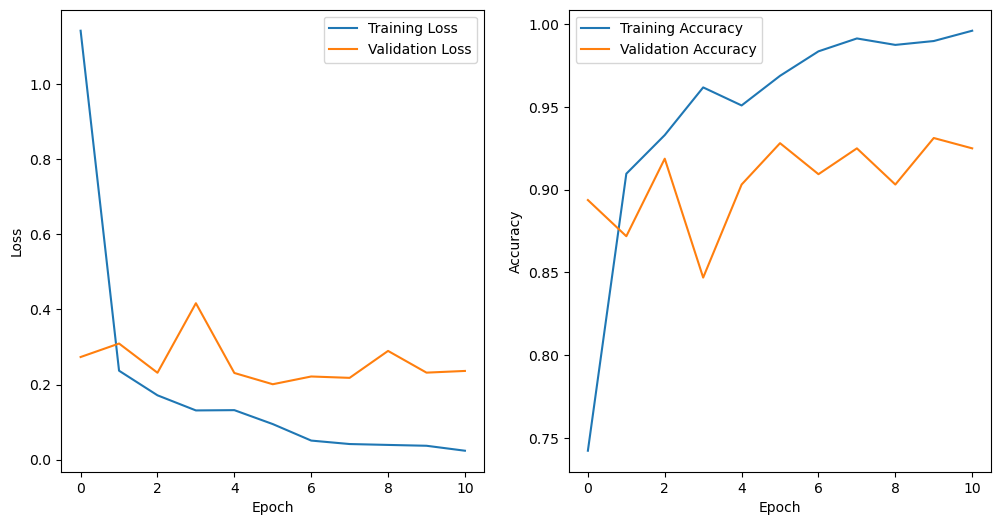

In [24]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Evaluate the model on validation data
loss, accuracy = vgg16_model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


11/11 [==============================] - 112s 10s/step - loss: 0.1952 - accuracy: 0.9303
Validation Loss: 0.19524617493152618
Validation Accuracy: 0.9303030371665955


## 4.3 ResNet-50 Model

In [26]:
# Load the ResNet-50 model pre-trained on ImageNet without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 9s 0us/step


In [27]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

In [28]:
# Create the model architecture by adding custom top layers
resnet_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [29]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Print a summary of the model architecture
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
# Train the model

# Set up early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
# restore_best_weights=True ensures that the model will restore the weights from the epoch with the best validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the ResNet-50 model using the fit method
# train_generator: The training data generator
# steps_per_epoch: The number of steps (batches of samples) to yield from the generator before declaring one epoch finished
# epochs: The number of epochs to train the model
# validation_data: The validation data generator
# validation_steps: The number of steps (batches of samples) to yield from the validation generator
# callbacks: A list of callback instances to apply during training (here we use early stopping)
history = resnet_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                          validation_data=val_generator, validation_steps=len(X_val)//32,
                          callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 162s 4s/step - loss: 3.0154 - accuracy: 0.5506 - val_loss: 0.6706 - val_accuracy: 0.6062
Epoch 2/50
41/41 [==============================] - 141s 3s/step - loss: 0.6827 - accuracy: 0.5755 - val_loss: 0.6679 - val_accuracy: 0.6031
Epoch 3/50
41/41 [==============================] - 162s 4s/step - loss: 0.6727 - accuracy: 0.5833 - val_loss: 0.6625 - val_accuracy: 0.5969
Epoch 4/50
41/41 [==============================] - 159s 4s/step - loss: 0.6550 - accuracy: 0.5841 - val_loss: 0.6604 - val_accuracy: 0.6031
Epoch 5/50
41/41 [==============================] - 140s 3s/step - loss: 0.6527 - accuracy: 0.5810 - val_loss: 0.6144 - val_accuracy: 0.5969
Epoch 6/50
41/41 [==============================] - 144s 4s/step - loss: 0.6362 - accuracy: 0.5818 - val_loss: 0.5929 - val_accuracy: 0.6000
Epoch 7/50
41/41 [==============================] - 151s 4s/step - loss: 0.6244 - accuracy: 0.5826 - val_loss: 0.5857 - val_accuracy: 0.6000
Epoch 8/50
41

In [34]:
# Evaluate the model on validation data
loss, accuracy = resnet_model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

11/11 [==============================] - 20s 2s/step - loss: 0.5547 - accuracy: 0.6000
Validation Loss: 0.5546714067459106
Validation Accuracy: 0.6000000238418579


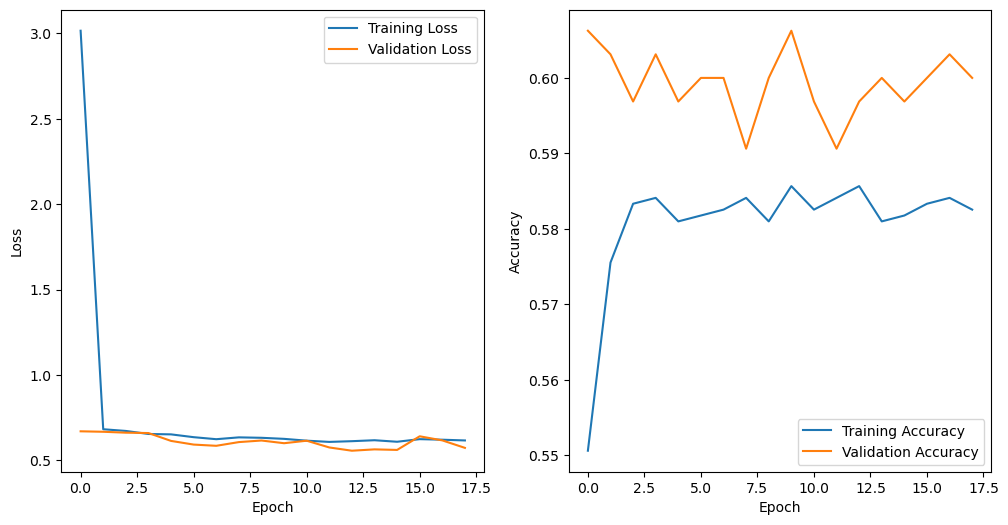

In [35]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5. Dumping Best Model

#### We see that we can achive best performance using VGG16 model with default values of different hyperparameters . Hence we dump this model for further use.

In [37]:
#Saving VGG16 model as h5 file
vgg16_model.save('model_vgg16.h5')